Pauline de la Rue | Alexandre Freyther | Antoine Poirier

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import scipy 
from fractions import Fraction # pour le rendu de l'axe des abscisses (pour les spectres)

# Modulation et démodulation DSB-SC

## Signal de départ

### Implémentation

In [30]:
a = -7 ## borne inférieure non nulle
b = 7 ## borne supérieure non nulle

f_max = 5/(4*b) # fréquence maximale du signal à transmettre
print("fréquence maximale du signal à transmettre : ", np.round(f_max,2), "Hz")

def x_inf(t):
    return np.cos(5*np.pi/2*t/b) + np.sin(np.pi*t/b) # la période minimale est donc 4b/5

def ind(t,a=a,b=b): # indicatrice entre a et b
    if t < a or t > b:
        return 0
    else :
        return 1
    
def x(t):
    return x_inf(t)*ind(t)

fréquence maximale du signal à transmettre :  0.18 Hz


### Choix des paramètres

In [31]:
N = 10**3
Lt = np.linspace(a,b,N)

fc = 5000*f_max # pour avoir fc >> f_max (par ex en radio FM, on a fc environ 100MHz pour un B d'environ 15kHZ)
f_inf = 100*fc # fréquence d'échantillonage


f_e = 2*f_max
print("La fréquence minimale d'échantillonage de x est de ",np.round(f_e,2), 'Hz')

print("B =", np.round(f_max,2), "Hz")
print("f_c = ", np.round(fc,2), "Hz")
print("f_inf = ", np.round(f_inf,2), "Hz")

La fréquence minimale d'échantillonage de x est de  0.36 Hz
B = 0.18 Hz
f_c =  892.86 Hz
f_inf =  89285.71 Hz


### Affichage du signal

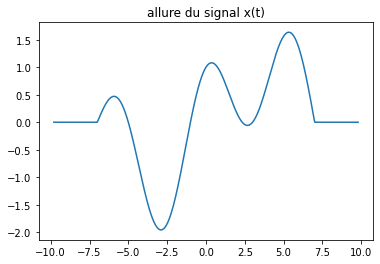

In [32]:
e = (b-a)/5

def afficher_signal(f,titre, N=1000, m=a-e, M=b+e): #titre est une chaine de caractère
    Lt = np.linspace(m,M,N)
    plt.figure()
    plt.plot(Lt,np.vectorize(f)(Lt))
    plt.title(titre)

afficher_signal(x,"allure du signal x(t)")

### Affichage du spectre

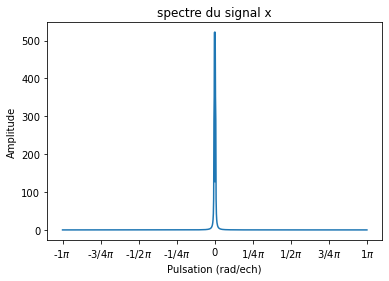

In [33]:
def discretise_signal(x, N=N): # a,b connus
    return np.vectorize(x)(np.linspace(a,b,N))

x_interpolé = discretise_signal(x)

def afficher_spectre(x_discret, titre): # Attention x_discret est discret 
    N = len(x_discret)
    plt.figure()
    # on veut afficher entre -pi et pi au lieu de 0 et 2pi
    X_normé_discret = np.abs(np.fft.fft(x_discret))
    res = np.zeros((N)) 
    res[:N//2] = X_normé_discret[N//2:]
    res[N//2:] = X_normé_discret[:N//2]
    plt.plot(np.linspace(-np.pi,np.pi,N),res)
    plt.title(titre)
    plt.ylabel('Amplitude')
    plt.xlabel('Pulsation (rad/ech)')
    plt.xticks(np.linspace(-np.pi,np.pi,9),[str(-Fraction(k*2/8))+'$\pi$' for k in range(1,5)][::-1]+[0]+[str(Fraction(k*2/8))+'$\pi$' for k in range(1,5)])
    plt.show()

afficher_spectre(x_interpolé, "spectre du signal x")

# Modulation et Démodulation DSB-SC

## Modulation - Démodulation avec cosinus

### Modulation

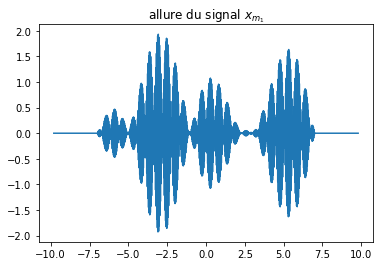

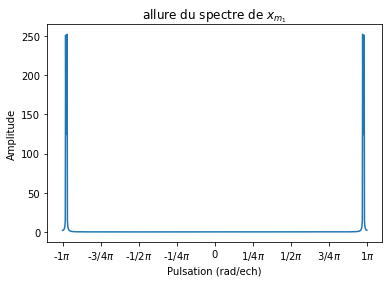

In [34]:
def xm1(t):
    return x(t)*np.cos(2*np.pi*fc*t)

afficher_signal(xm1, "allure du signal $x_{m_1}$", N=1000) # si on met 100 ca change grandement

xm1_discret = discretise_signal(xm1)
afficher_spectre(xm1_discret,"allure du spectre de $x_{m_1}$")

Comme son som l'indique (Double-SideBand Supressed-Carrier), la modulation donne un **spectre à une bande de chaque côté** et rien au milieu.

### Démodulation synchrone "analogique"

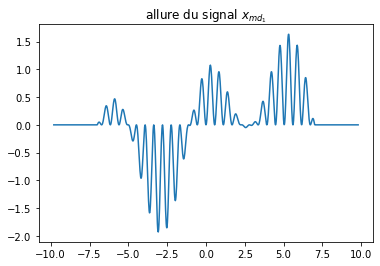

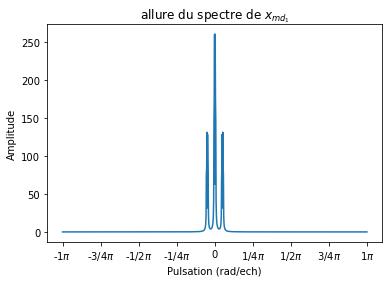

In [35]:
def xmd1(t):
    return xm1(t)*np.cos(2*np.pi*fc*t)

afficher_signal(xmd1, "allure du signal $x_{md_1}$", N=1000);


xmd1_discret = discretise_signal(xmd1,N)
afficher_spectre(xmd1_discret,"allure du spectre de $x_{md_1}$")


On va filtrer $x_{md}$ par un passe-bas : Gardons uniquement le 1er pic du spectre (ou plus généralement les pulsations entre 0 et 0,2 rad/ech, ie en gros les 20 premières ; on met le reste à 0.

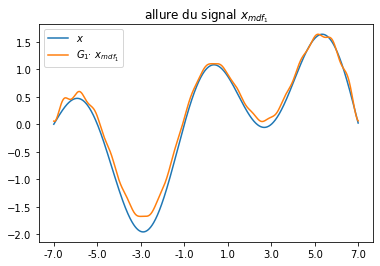

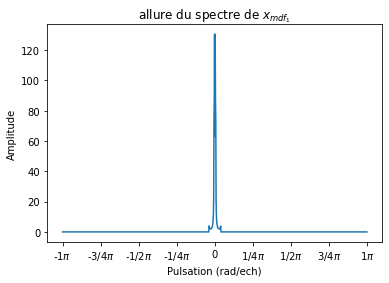

In [36]:
Xmd1_discret = np.fft.fft(xmd1_discret)
Xmdf1_discret = Xmd1_discret.copy()
deb = 20 # à partir de 20 on met tout à 0
Xmdf1_discret[deb:] = 0



xmdf1 = np.real(np.fft.ifft(Xmdf1_discret)) # on ne prend que la partie réelle

y1 = (max(xmdf1)+min(xmdf1))/2


G1 = max(x_interpolé)/max(xmdf1) # facteur d'atténuation de l'amplitude


plt.figure() 
Ln = np.arange(N)
plt.plot(Ln,np.vectorize(x)((Ln-N/2)*b/500),label="$x$")
plt.plot(xmdf1*G1, label="$G_1 \dot \ x_{mdf_1}$")

# on recadre entre -7 et 7 au lieu d'avoir la suite entre 0 et 1000
plt.xticks(np.linspace(0,N,8),np.vectorize(str)(np.linspace(-7,7,8))) 
plt.legend()
plt.title("allure du signal $x_{mdf_1}$")
plt.show()


afficher_spectre(xmdf1, "allure du spectre de $x_{mdf_1}$")

In [37]:
print("Après filtrage pas un passe bas, on ne retrouve pas exactement le signal d'origine.")
print("L'amplitude a été divisée d'un facteur", np.round(G1,2))
print("Les deux signaux gardent toutefois la même allure.")

Après filtrage pas un passe bas, on ne retrouve pas exactement le signal d'origine.
L'amplitude a été divisée d'un facteur 3.7
Les deux signaux gardent toutefois la même allure.


Le théorème de Shannon assure que l'on doit avoir $f_e \geq 2f_{max}$
<br/> Le fréquence minimale d'échantillonage possible est donc $f_{e,min} = 2f_{max}$

In [38]:
# Pour x_m, on a clairement la pulsation maximale :
wm1 = np.pi #(en rad/échantillon)

# d'où
fm1 = wm1/(2*np.pi)*N

print("Ainsi la fréquence minimale d'échantillonage pour x_m serait de ", 2*fm1, "Hz")

Ainsi la fréquence minimale d'échantillonage pour x_m serait de  1000.0 Hz


**Bilan :** On ne peut pas échantilloner $x_m$ à 0.36 Hz (sinon on perd de l'information : c'est le repliement)

### Démodulation synchrone par sous échantillonage

On remarque que les max locaux (lorsque $x(t) > 0$) et les min locaux (lorsque $x(t)<0$) du signal $x_{md}$ sont également des points du signal d'origne $x$.
<br> Ainsi en échantillonant ces points là uniquement, on retrouverait l'allure du signal d'origine.

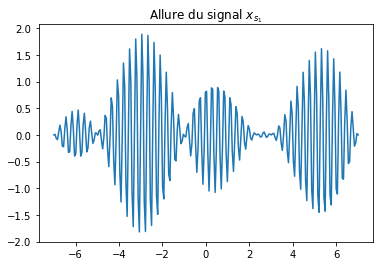

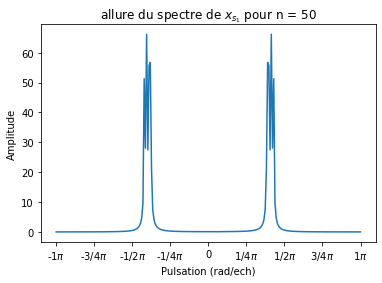

In [39]:
n = 50
fs = fc/n

# On suppose que l'unité des abscisses pour les signaux est la seconde.

Lt_echantillonnage = np.linspace(a,b,int(fs*(b-a)))
xs1_discret = np.vectorize(xm1)(Lt_echantillonnage)

plt.figure()
plt.plot(Lt_echantillonnage,xs1_discret, label="$x_{s_1}$ (echantillonnage avec n = "+str(n))
plt.title("Allure du signal $x_{s_1}$")
plt.show()

afficher_spectre(xs1_discret, "allure du spectre de $x_{s_1}$ pour n = "+str(n))

On constate en faisant varier les valeurs de que pour $n \geq 100$, les max et min ne correspondent plus.
<br/> **Ainsi** on a $f_{s,min} = \frac{f_m}{100} = 1,8 \times 10^{-3} Hz$

### Retour au signal d'origine ?

In [40]:
# On extrait les max locaux si x(t) > 0 et les min locaux si x(t) < 0

def demodulation_synchrone_sous_echantillonage(x, xs_discret):
    N = len(xs_discret)
    Lt = np.linspace(-b,b,N)
    res = [xs_discret[0]]
    Lt_res = [-b]
    for i in range(1,N-1):
        if x(Lt[i]) >=0 :
            if (xs_discret[i] > xs_discret[i-1]) & (xs_discret[i] > xs_discret[i+1]):
                res.append(xs_discret[i])
                Lt_res.append(Lt[i])
        else : # x(Lt[i]) < 0 :
            if (xs_discret[i] < xs_discret[i-1]) & (xs_discret[i] < xs_discret[i+1]):
                res.append(xs_discret[i])
                Lt_res.append(Lt[i])
    res.append(xs_discret[-1])
    Lt_res.append(b)
    return np.array(Lt_res), np.array(res)

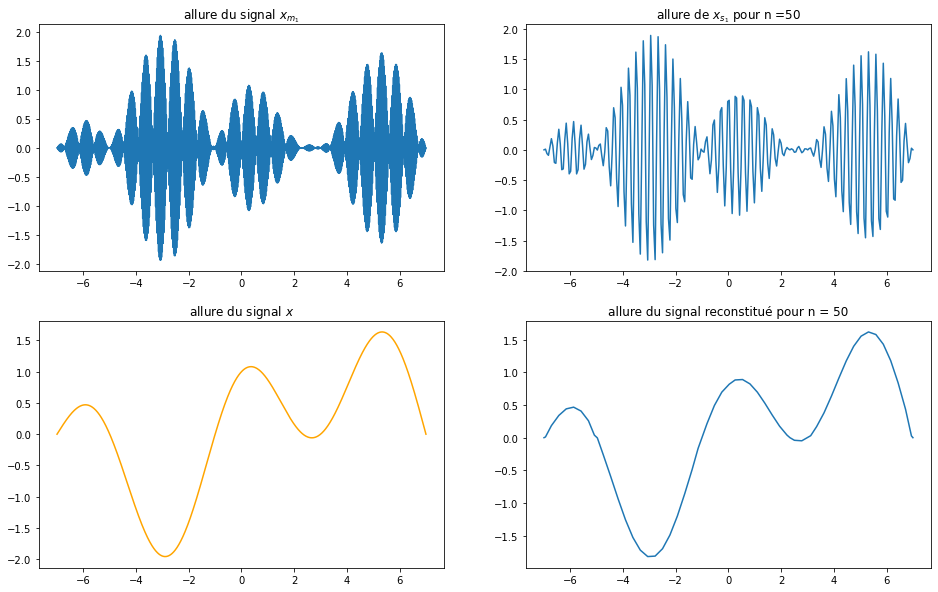

In [41]:
fig, ax = plt.subplots(2,2,figsize=(16,10))
ax[0,0].plot(Lt,np.vectorize(xm1)(Lt))
ax[0,0].set_title("allure du signal $x_{m_1}$")

Lt_echantillonnage = np.linspace(a,b,int(fs*(b-a)))
xs1_discret = np.vectorize(xm1)(Lt_echantillonnage) 
ax[0,1].plot(Lt_echantillonnage,xs1_discret)
ax[0,1].set_title("allure de $x_{s_1}$ pour n ="+str(n))

ax[1,0].plot(Lt,np.vectorize(x)(Lt),color='orange')
ax[1,0].set_title("allure du signal $x$")

Lt_dsse1, dsse1 = demodulation_synchrone_sous_echantillonage(x, xs1_discret)

ax[1,1].plot(Lt_dsse1, dsse1)
ax[1,1].set_title("allure du signal reconstitué pour n = "+str(n))
plt.show()

**Bilan :** On retrouve l'allure du signal d'origne $x$

**Intérêt :** Cette procédure permet à pour un signal noyé dans un bruit important d'être retrouvé.
<li>Temporellement le signal devrait être reconstitué dans les grandes lignes.</li>
<li>Fréquentiellement on élimine les fréquences correspondant à la perturbation. L'intérêt de cette méthode se trouve dans la fréquence d'échantillonage, qui est ici étant très faible.</li>

## Modulation - démodulation avec sinus

### Modulation

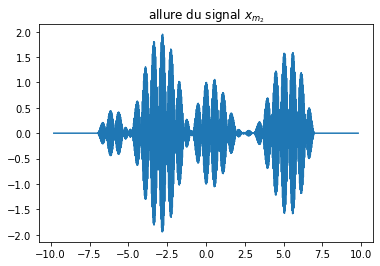

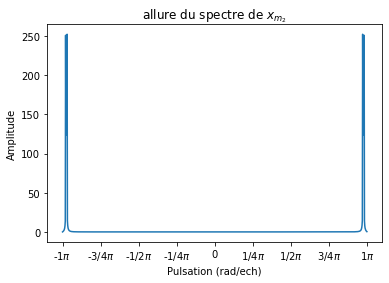

In [42]:
def xm2(t):
    return x(t)*np.sin(2*np.pi*fc*t)

afficher_signal(xm2, "allure du signal $x_{m_2}$", N=1000) # si on met 100 ca change grandement

xm2_discret = discretise_signal(xm2,N)
afficher_spectre(xm2_discret,"allure du spectre de $x_{m_2}$")

**Rq :** On retrouve une démodulation DSB-SC

### Démodulation syncrhone analogique

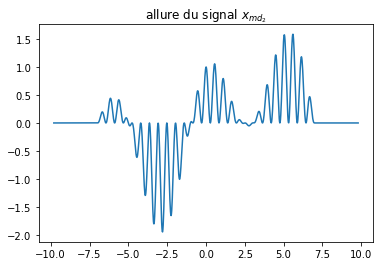

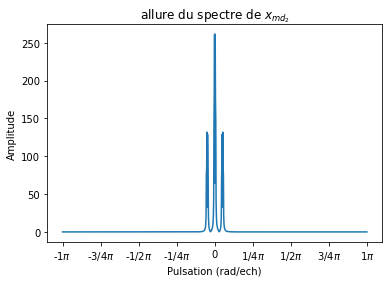

In [43]:
def xmd2(t):
    return xm2(t)*np.sin(2*np.pi*fc*t)

afficher_signal(xmd2, "allure du signal $x_{md_2}$");


xmd2_discret = discretise_signal(xmd2,N)
afficher_spectre(xmd2_discret,"allure du spectre de $x_{md_2}$")



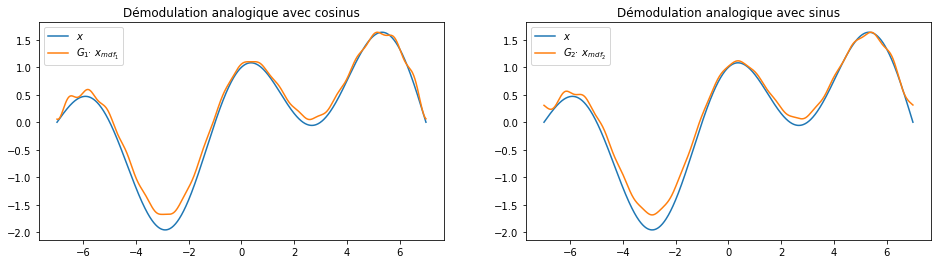

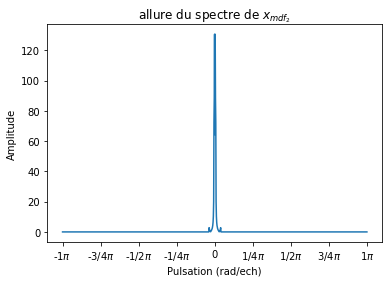

In [44]:
Xmd2_discret = np.fft.fft(xmd2_discret)
Xmdf2_discret = Xmd2_discret.copy()
deb = 20 # à partir de 20 on met tout à 0
Xmdf2_discret[deb:] = 0



xmdf2 = np.real(np.fft.ifft(Xmdf2_discret)) # on ne prend que la partie réelle

y2 = (max(xmdf2)+min(xmdf2))/2


G2 = max(x_interpolé)/max(xmdf2) # facteur d'atténuation de l'amplitude


fix, ax = plt.subplots(1,2,figsize=(16,4))

ax[0].plot(Lt,np.vectorize(x)(Lt),label="$x$")
ax[0].plot(Lt,xmdf1*G1, label="$G_1 \dot \ x_{mdf_1}$")
ax[0].set_title("Démodulation analogique avec cosinus")
ax[0].legend()

ax[1].plot(Lt,np.vectorize(x)(Lt),label="$x$")
ax[1].plot(Lt,xmdf2*G2, label="$G_2 \dot \ x_{mdf_2}$")
ax[1].set_title("Démodulation analogique avec sinus")
ax[1].legend()

plt.show()


afficher_spectre(xmdf2, "allure du spectre de $x_{mdf_2}$")

**Commentaire :** On observe une très faible différence à ce niveau entre les deux méthodes

### Démodulation syncrhone par sous-échantillonage

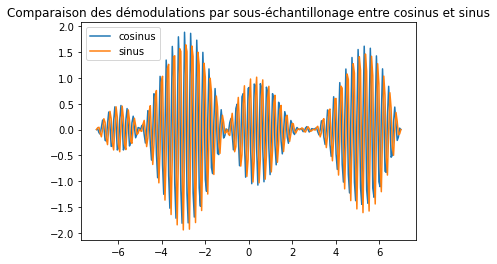

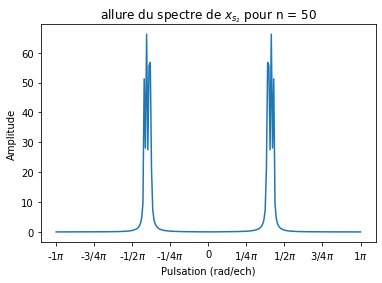

In [45]:
#n = 50 
#fs = fc/n 

Lt_echantillonnage = np.linspace(a,b,int(fs*(b-a)))
xs2_discret = np.vectorize(xm2)(Lt_echantillonnage)



plt.figure()

plt.plot(Lt_echantillonnage,xs1_discret, label="cosinus")
plt.plot(Lt_echantillonnage,xs2_discret, label="sinus")
plt.legend()
plt.title("Comparaison des démodulations par sous-échantillonage entre cosinus et sinus")
plt.show()


afficher_spectre(xs2_discret, "allure du spectre de $x_{s_2}$ pour n = "+str(n))

**Remarques :** 
<li> On observe un léger décalage temporel entre le deux signaux $x_{s_1}$ et $x_{s_2}$ </li>
<li> On observe un léger décalage d'amplitude entre le deux signaux $x_{s_1}$ et $x_{s_2}$ </li>

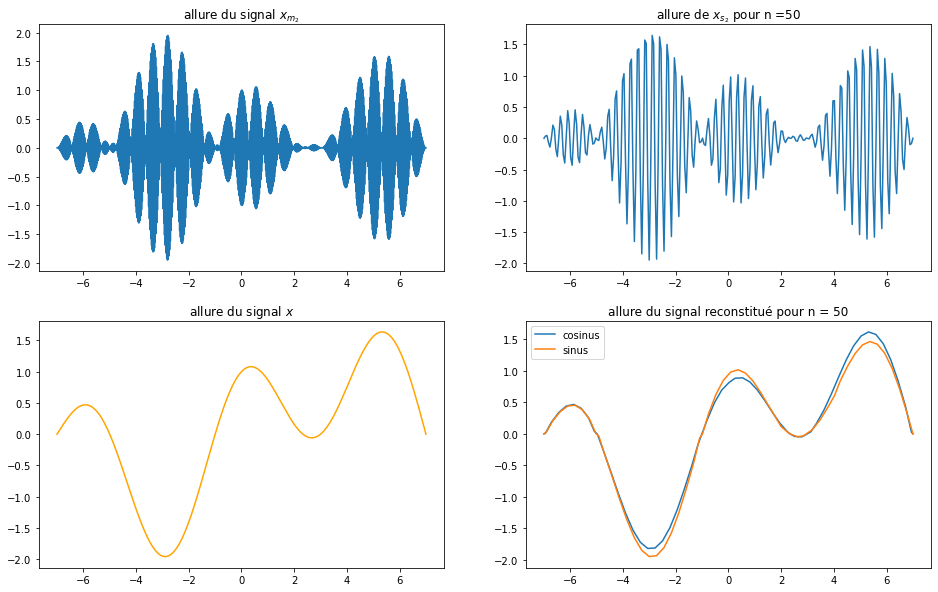

In [46]:
fig, ax = plt.subplots(2,2,figsize=(16,10))
ax[0,0].plot(Lt,np.vectorize(xm2)(Lt))
ax[0,0].set_title("allure du signal $x_{m_2}$")

Lt_echantillonnage = np.linspace(a,b,int(fs*(b-a)))
xs2_discret = np.vectorize(xm2)(Lt_echantillonnage) 
ax[0,1].plot(Lt_echantillonnage,xs2_discret)
ax[0,1].set_title("allure de $x_{s_2}$ pour n ="+str(n))

ax[1,0].plot(Lt,np.vectorize(x)(Lt),color='orange')
ax[1,0].set_title("allure du signal $x$")


Lt_dsse2, dsse2 = demodulation_synchrone_sous_echantillonage(x, xs2_discret)

ax[1,1].plot(Lt_dsse1, dsse1, label = 'cosinus')
ax[1,1].plot(Lt_dsse2, dsse2, label = 'sinus')
ax[1,1].set_title("allure du signal reconstitué pour n = "+str(n))
ax[1,1].legend()

plt.show()

# Modulation et démodulation QAM

Prenons par exemple :
<br> $x_i(t) = x(t) = cos(\frac{5 \pi t}{2b})+sin(\frac{\pi t}{b})$
<br> $x_q(t) = cos(\frac{9 \pi t}{8b})-sin(\frac{5 \pi t}{7b})$
<br>
<br> Ainsi on garde $f_{max}$

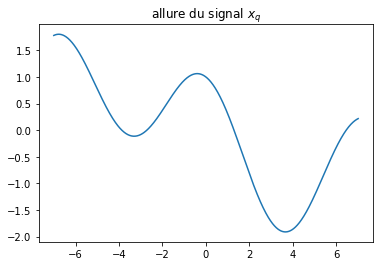

In [47]:
# xi <-- x

def xi(t):
    return x(t)



def xq_inf(t):
    return np.cos(2*np.pi*t/b)-np.sin(5*np.pi*t/(b*7))
 
def xq(t):
    return xq_inf(t)*ind(t,a,b)

afficher_signal(xq, "allure du signal $x_q$", N, a, b)

In [48]:
xi_discret = np.vectorize(xi)(Lt)
Xi = np.fft.fft(xi_discret)

xq_discret = np.vectorize(xq)(Lt)
Xq = np.fft.fft(xq_discret)

## Modulation



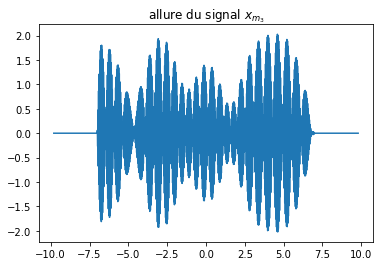

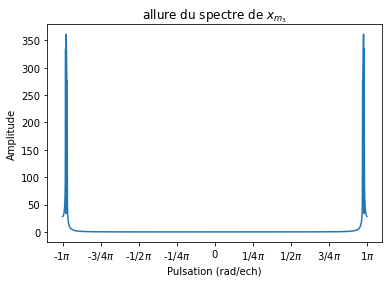

In [49]:
def xm3(t):
    return xi(t)*np.cos(2*np.pi*fc*t)+xq(t)*np.sin(2*np.pi*fc*t)

afficher_signal(xm3, "allure du signal $x_{m_3}$", N=1000) # si on met 100 ca change grandement

xm3_discret = discretise_signal(xm3)
afficher_spectre(xm3_discret,"allure du spectre de $x_{m_3}$")

## Démodulation synchrone analogique

### Avec modulation cos

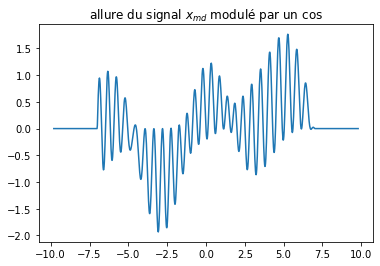

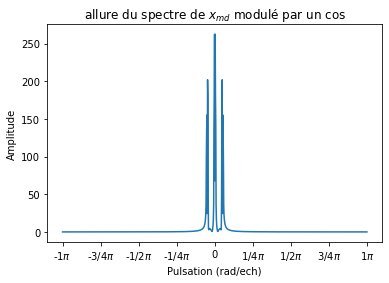

In [50]:
def xmd3(t):
    return xm3(t)*np.cos(2*np.pi*fc*t)

afficher_signal(xmd3, "allure du signal $x_{md}$ modulé par un cos");


xmd3_discret = discretise_signal(xmd3,N)
afficher_spectre(xmd3_discret,"allure du spectre de $x_{md}$ modulé par un cos")



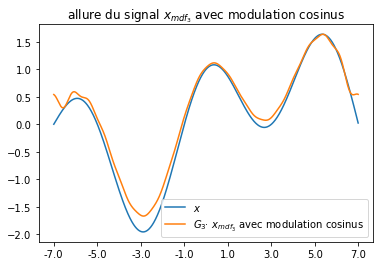

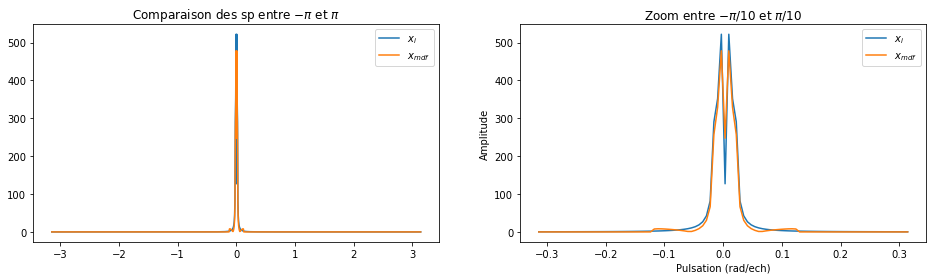

In [51]:
Xmd3_discret = np.fft.fft(xmd3_discret)
Xmdf3_discret = Xmd3_discret.copy()
deb = 20 # à partir de 20 on met tout à 0
Xmdf3_discret[deb:] = 0



xmdf3 = np.real(np.fft.ifft(Xmdf3_discret)) # on ne prend que la partie réelle

y3 = (max(xmdf3)+min(xmdf3))/2


G3 = max(xi_discret)/max(xmdf3) # facteur d'atténuation de l'amplitude


plt.figure() 
Ln = np.arange(N)
plt.plot(Ln,np.vectorize(xi)((Ln-N/2)*b/500),label="$x$")
plt.plot(xmdf3*G3, label="$G_3 \dot \ x_{mdf_3}$ avec modulation cosinus")

# on recadre entre -7 et 7 au lieu d'avoir la suite entre 0 et 1000
plt.xticks(np.linspace(0,N,8),np.vectorize(str)(np.linspace(-7,7,8))) 
plt.legend()
plt.title("allure du signal $x_{mdf_3}$ avec modulation cosinus")
plt.show()




fig,ax = plt.subplots(1,2,figsize=(16,4))

# on veut afficher entre -pi et pi au lieu de 0 et 2pi

res2 = np.zeros((N)) 
res2[:N//2] = np.abs(Xi)[N//2:]
res2[N//2:] = np.abs(Xi)[:N//2]
ax[0].plot(np.linspace(-np.pi,np.pi,N),res2, label ="$x_i$")

Xmdf3_discret = np.fft.fft(xmdf3)
res1 = np.zeros((N)) 
res1[:N//2] = np.abs(Xmdf3_discret)[N//2:]
res1[N//2:] = np.abs(Xmdf3_discret)[:N//2]
ax[0].plot(np.linspace(-np.pi,np.pi,N),res1*G3, label="$x_{mdf}$")

ax[0].legend()
ax[0].set_title("Comparaison des sp entre $-\pi$ et $\pi$")

# Avec un zoom entre -pi/10 et pi/10
M = N//10

res2 = np.zeros((M)) 
res2[:M//2] = np.abs(Xi)[N-M//2:]
res2[M//2:] = np.abs(Xi)[:M//2]
ax[1].plot(np.linspace(-np.pi/10,np.pi/10,M),res2, label ="$x_i$")

res1 = np.zeros(M) 
res1[:M//2] = np.abs(Xmdf3_discret)[N-M//2:]
res1[M//2:] = np.abs(Xmdf3_discret)[:M//2]
ax[1].plot(np.linspace(-np.pi/10,np.pi/10,M),res1*G3, label="$x_{mdf}$")


ax[1].legend()
ax[1].set_title("Zoom entre $-\pi/10$ et $ \pi/10$")

plt.ylabel('Amplitude')
plt.xlabel('Pulsation (rad/ech)')
plt.show()





**Bilan :** En filtrant par $cos(2\pi f_c t)$, on retrouve $x_i$



### Avec modulation sin



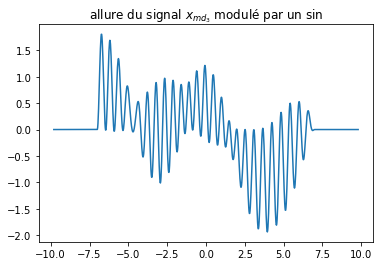

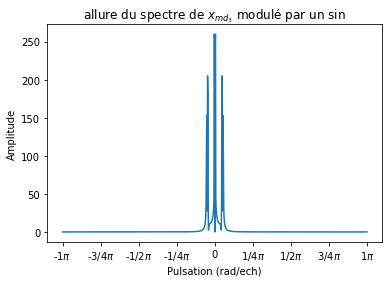

In [52]:
def xmd3sin(t):
    return xm3(t)*np.sin(2*np.pi*fc*t)

afficher_signal(xmd3sin, "allure du signal $x_{md_3}$ modulé par un sin");


xmd3sin_discret = discretise_signal(xmd3sin,N)
afficher_spectre(xmd3sin_discret,"allure du spectre de $x_{md_3}$ modulé par un sin")

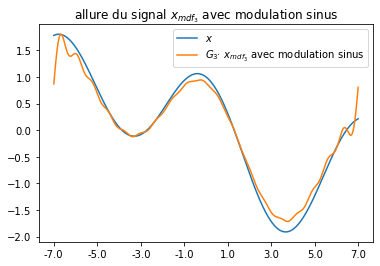

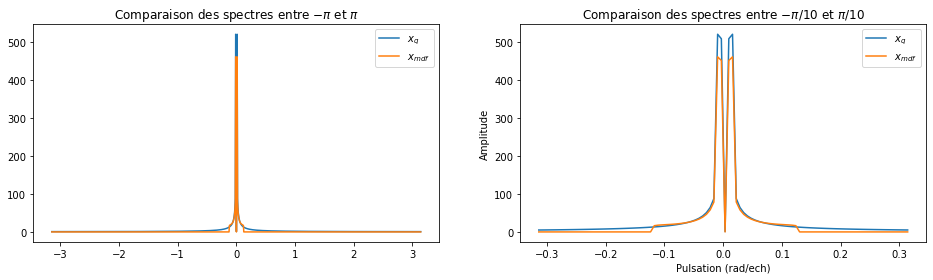

In [53]:
Xmd3sin_discret = np.fft.fft(xmd3sin_discret)
Xmdf3sin_discret = Xmd3sin_discret.copy()
deb = 20 # à partir de 20 on met tout à 0
Xmdf3sin_discret[deb:] = 0



xmdf3sin = np.real(np.fft.ifft(Xmdf3sin_discret)) # on ne prend que la partie réelle

y3sin = (max(xmdf3sin)+min(xmdf3sin))/2


G3sin = max(xq_discret)/max(xmdf3sin) # facteur d'atténuation de l'amplitude


plt.figure() 
Ln = np.arange(N)
plt.plot(Ln,np.vectorize(xq)((Ln-N/2)*b/500),label="$x$")
plt.plot(xmdf3sin*G3sin, label="$G_3 \dot \ x_{mdf_3}$ avec modulation sinus")

# on recadre entre -7 et 7 au lieu d'avoir la suite entre 0 et 1000
plt.xticks(np.linspace(0,N,8),np.vectorize(str)(np.linspace(-7,7,8))) 
plt.legend()
plt.title("allure du signal $x_{mdf_3}$ avec modulation sinus")
plt.show()




fig,ax = plt.subplots(1,2,figsize=(16,4))

# on veut afficher entre -pi et pi au lieu de 0 et 2pi

res2 = np.zeros((N)) 
res2[:N//2] = np.abs(Xq)[N//2:]
res2[N//2:] = np.abs(Xq)[:N//2]
ax[0].plot(np.linspace(-np.pi,np.pi,N),res2, label ="$x_q$")

Xmdf3sin_discret = np.fft.fft(xmdf3sin)
res1 = np.zeros((N)) 
res1[:N//2] = np.abs(Xmdf3sin_discret)[N//2:]
res1[N//2:] = np.abs(Xmdf3sin_discret)[:N//2]
ax[0].plot(np.linspace(-np.pi,np.pi,N),res1*G3sin, label="$x_{mdf}$")

ax[0].legend()
ax[0].set_title("Comparaison des spectres entre $-\pi$ et $\pi$")

# Avec un zoom entre -pi/10 et pi/10
M = N//10

res2 = np.zeros((M)) 
res2[:M//2] = np.abs(Xq)[N-M//2:]
res2[M//2:] = np.abs(Xq)[:M//2]
ax[1].plot(np.linspace(-np.pi/10,np.pi/10,M),res2, label ="$x_q$")

res1 = np.zeros(M) 
res1[:M//2] = np.abs(Xmdf3sin_discret)[N-M//2:]
res1[M//2:] = np.abs(Xmdf3sin_discret)[:M//2]
ax[1].plot(np.linspace(-np.pi/10,np.pi/10,M),res1*G3sin, label="$x_{mdf}$")


ax[1].legend()
ax[1].set_title("Comparaison des spectres entre $-\pi/10$ et $ \pi/10$")

plt.ylabel('Amplitude')
plt.xlabel('Pulsation (rad/ech)')
plt.show()

**Bilan :** En filtrant par $sin(2\pi f_c t)$, on retrouve $x_q$

## Demodulation synchrone par sous échantillonage

### Avec modulation cos

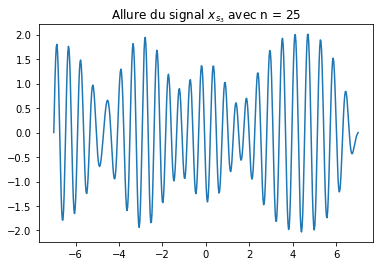

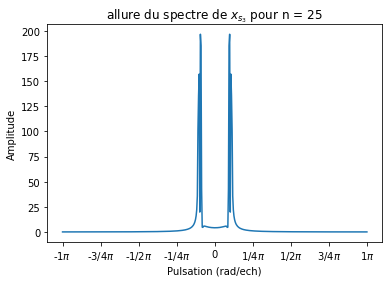

In [54]:
n = 25
fs = fc/n
Lt_echantillonnage = np.linspace(a,b,int(fs*(b-a)))

xs3_discret = np.vectorize(xm3)(Lt_echantillonnage)

plt.figure()
plt.plot(Lt_echantillonnage,xs3_discret)
plt.title("Allure du signal $x_{s_3}$ avec n = "+str(n))
plt.show()

afficher_spectre(xs3_discret, "allure du spectre de $x_{s_3}$ pour n = "+str(n))

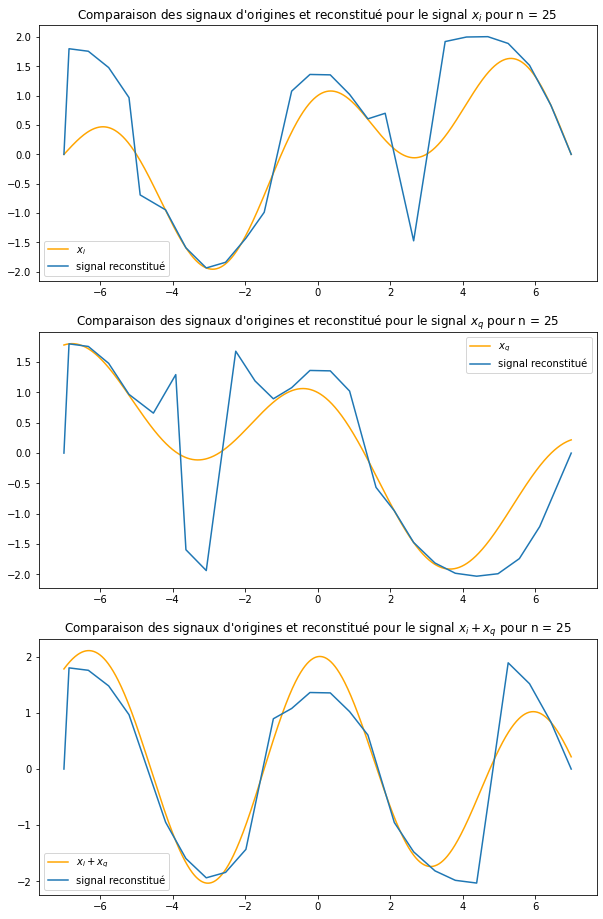

In [71]:
fig, ax = plt.subplots(3,1,figsize=(10,16))


ax[0].plot(Lt,np.vectorize(xi)(Lt),color='orange',label="$x_i$")
Lt_dsse3, dsse3 = demodulation_synchrone_sous_echantillonage(xi, xs3_discret)
ax[0].plot(Lt_dsse3, dsse3, label="signal reconstitué")
ax[0].legend()
ax[0].set_title("Comparaison des signaux d'origines et reconstitué pour le signal $x_i$ pour n = "+str(n))


ax[1].plot(Lt,np.vectorize(xq)(Lt),color='orange',label="$x_q$")
#ax[0,0].set_title("allure du signal $x_i$")
Lt_dsse4, dsse4 = demodulation_synchrone_sous_echantillonage(xq, xs3_discret)
ax[1].plot(Lt_dsse4, dsse4, label="signal reconstitué")
ax[1].legend()
ax[1].set_title("Comparaison des signaux d'origines et reconstitué pour le signal $x_q$ pour n = "+str(n))


def xi_plus_xq(t):
    return xi(t)+xq(t)

ax[2].plot(Lt,np.vectorize(xi_plus_xq)(Lt),color='orange',label="$x_i+x_q$")
Lt_dsse5, dsse5 = demodulation_synchrone_sous_echantillonage(xi_plus_xq, xs3_discret)
ax[2].plot(Lt_dsse5, dsse5, label="signal reconstitué")
ax[2].legend()
ax[2].set_title("Comparaison des signaux d'origines et reconstitué pour le signal $x_i + x_q$ pour n = "+str(n))


plt.show()

**Bilan :** Ici la démodulation par sous-échantillonnage est moins précise que la démodulation analogique



# Modulation et démodulation SSB-SC

Les spectres dans la partie I étaient symétrique par rapport à 0, on peut se limiter à la partie entre 0 et $\pi$ par exemple. 
<br> On passe ainsi de deux bandes à une.